In [1]:
%load_ext autoreload
%autoreload 2

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Загрузка данных

In [2]:
from data import load_dataset

data, annotations = load_dataset('dataset_kids')

## Построение признаков

In [3]:
def compute_MWD(ic) -> float:
    return ic.weights.abs().max() / ic.weights.abs().mean()

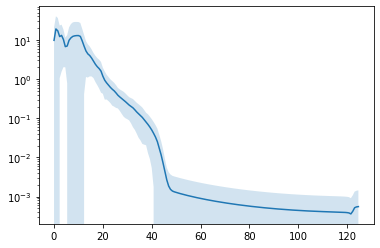

In [4]:
i_component = data['IC000369']

freqs, powers = i_component.psd(verbose=False)

plt.fill_between(freqs, powers.mean(axis=0) - powers.std(axis=0), powers.mean(axis=0) + powers.std(axis=0), alpha=0.2)
plt.semilogy(freqs, powers.mean(axis=0))

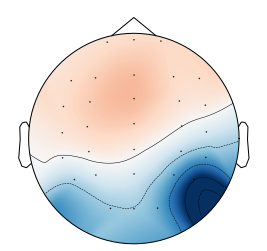

In [5]:
i_component.plot_topomap()

In [6]:
from features import build_feature_df

features = build_feature_df(data, custom_features={'MWD': compute_MWD})
features

,K,MEV,SAD,SVD,SED,MIF,MWD
IC000262,1.072924,7.849818,1.218625,0.312472,0.034570,0.048681,4.587533
IC000263,-0.258669,2.826228,-0.098488,-0.017333,0.198680,0.194712,1.949485
IC000264,-0.281039,2.405500,0.048190,-0.005600,0.195810,0.135989,2.367103
IC000265,-0.109386,2.304496,-0.153483,-0.047035,0.102357,0.137081,4.820455
IC000266,-0.184636,2.180311,-0.098674,-0.010143,0.185123,0.238028,2.937044
...,...,...,...,...,...,...,...
IC000877,-0.146957,6.988684,0.042727,-0.004911,0.025780,0.121094,2.695143
IC000878,-0.239456,3.270491,-0.024471,-0.000694,0.116370,0.088207,2.609675
IC000879,-0.205477,4.605998,0.052680,0.000121,0.037387,0.114119,2.478707
IC000880,-0.177250,3.021220,-0.042368,-0.000086,0.097905,0.117893,2.260824


In [7]:
from data import build_target_df

targets = build_target_df(annotations)
targets = targets.loc[:, targets.any(axis=0)]
targets

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_eyes_v,flag_muscles,flag_heart,flag_ch_noise
IC000262,False,False,False,False,False,True,False,False,False
IC000263,True,False,False,False,False,False,False,False,False
IC000264,True,False,False,False,False,False,False,False,False
IC000265,True,False,False,False,False,False,False,False,False
IC000266,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
IC000877,True,False,False,False,False,False,False,False,False
IC000878,True,False,False,False,False,False,False,False,False
IC000879,True,False,False,False,False,False,False,False,False
IC000880,True,False,False,False,False,False,False,False,False


In [8]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay

def plot_roc_curve(ax, y_true, y_pred, title=None, lw=2, color='darkorange'):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    ax.set_title(title)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax, color=color, lw=lw)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')


def plot_pr_curve(ax, y_true, y_pred, title=None, lw=2, color='darkorange'):
    p, rec, _ = precision_recall_curve(y_true, y_pred)
    avg_prec = average_precision_score(y_true, y_pred)
    ax.set_title(title)
    PrecisionRecallDisplay(precision=p, recall=rec,
                           average_precision=avg_prec).plot(ax=ax, color=color, lw=lw)


def plot_curves(y_true, y_pred, feature_name=None, figsize=(13, 5), **kwargs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(feature_name)
    plot_roc_curve(ax1, y_true, y_pred, 'ROC curve', **kwargs)
    plot_pr_curve(ax2, y_true, y_pred, 'PR curve', **kwargs)


In [10]:
from itertools import product

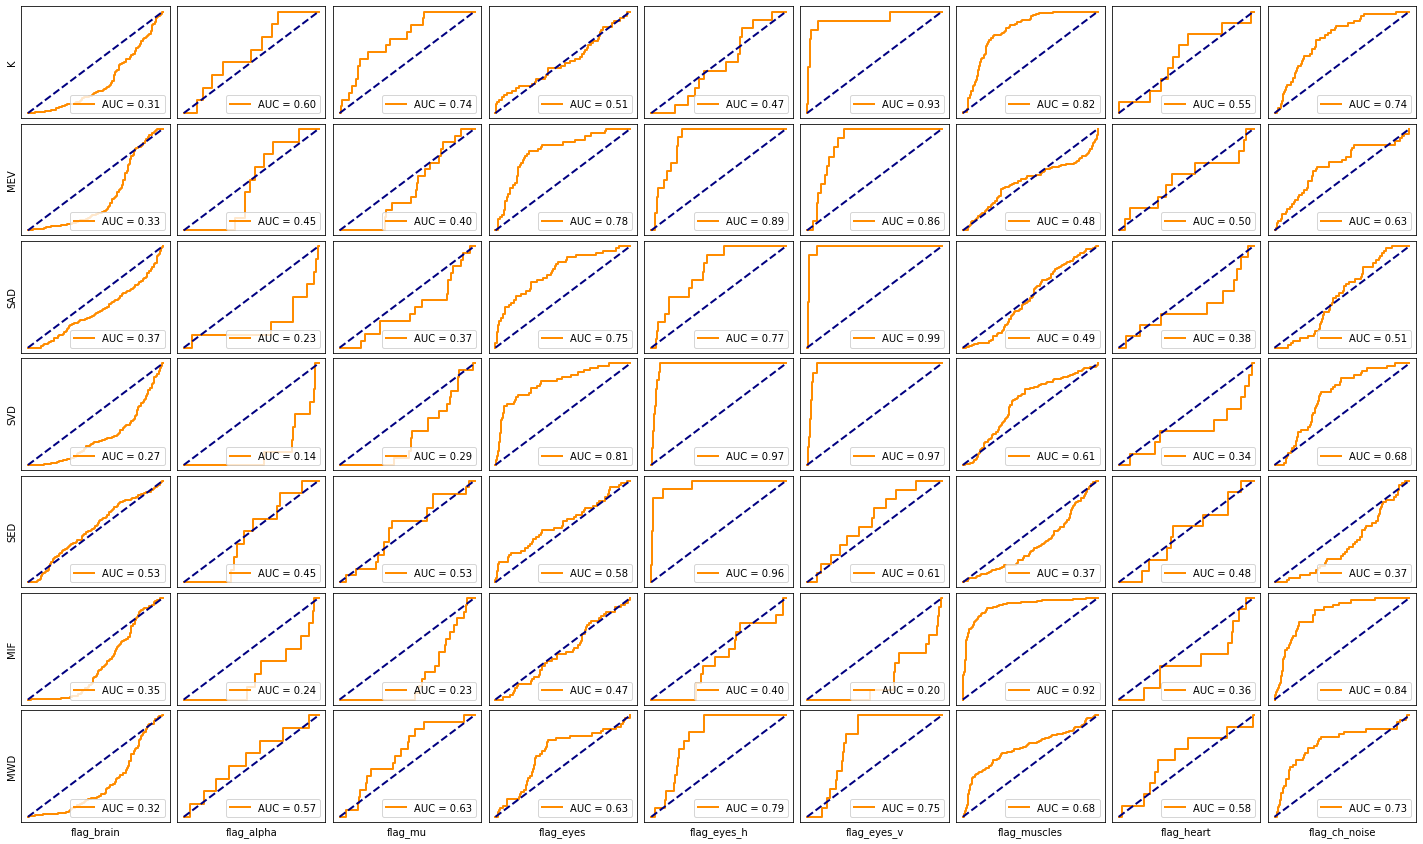

In [11]:
fig, axes = plt.subplots(len(features.columns), len(targets.columns), figsize=(25, 15))

for (f_name, t_name), ax in zip(product(features, targets), axes.ravel()):
    plot_roc_curve(ax, targets[t_name], features[f_name])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

for f_idx, f_name in enumerate(features):
    axes[f_idx, 0].set_ylabel(f_name)

for t_idx, t_name in enumerate(targets):
    axes[-1, t_idx].set_xlabel(t_name)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

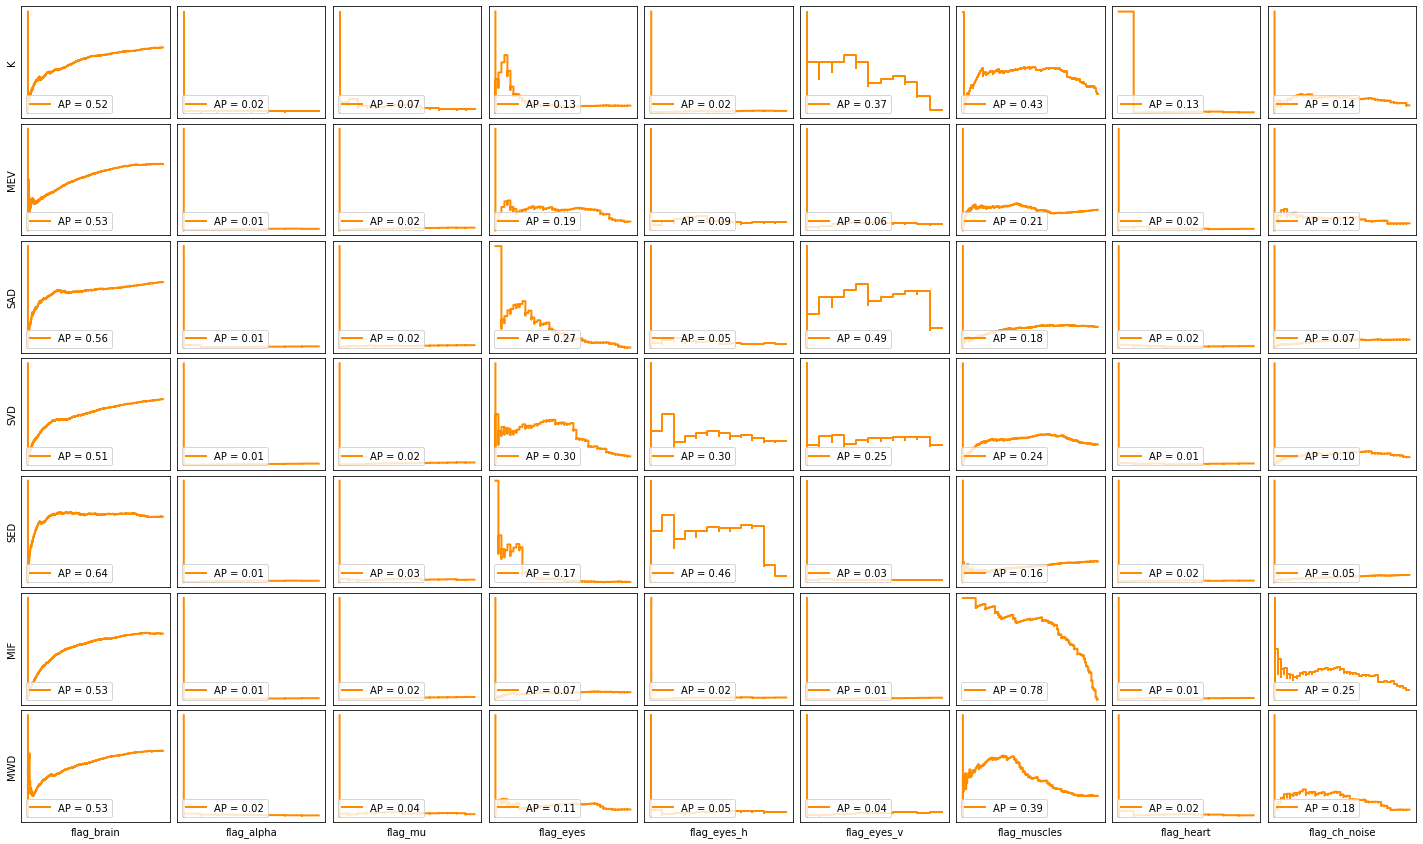

In [12]:
fig, axes = plt.subplots(len(features.columns), len(targets.columns), figsize=(25, 15))

for (f_name, t_name), ax in zip(product(features, targets), axes.ravel()):
    plot_pr_curve(ax, targets[t_name], features[f_name])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

for f_idx, f_name in enumerate(features):
    axes[f_idx, 0].set_ylabel(f_name)

for t_idx, t_name in enumerate(targets):
    axes[-1, t_idx].set_xlabel(t_name)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

## Обучение модели

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, plot_roc_curve

In [15]:
lr = LogisticRegression(solver='liblinear')

Вертикалные движения глаз.

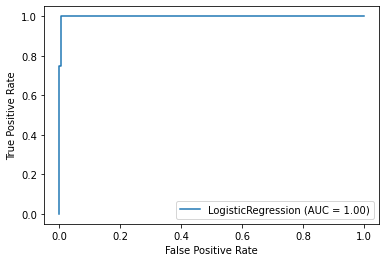

In [35]:
y = targets['flag_eyes_v']

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3)

lr.fit(X_train, y_train)
plot_roc_curve(lr, X_test, y_test)

In [36]:
features.columns[lr.coef_.argsort().ravel()[::-1]]

Index(['SAD', 'K', 'SVD', 'MEV', 'SED', 'MWD', 'MIF'], dtype='object')

Горизонтальные движения глаз.

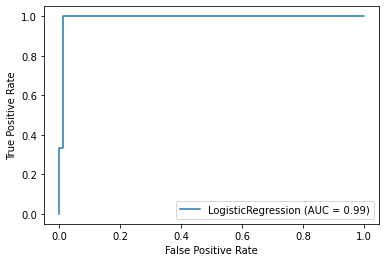

In [37]:
y = targets['flag_eyes_h']

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3)

lr.fit(X_train, y_train)
plot_roc_curve(lr, X_test, y_test)

In [38]:
features.columns[lr.coef_.argsort().ravel()[::-1]]

Index(['SED', 'SVD', 'SAD', 'K', 'MEV', 'MWD', 'MIF'], dtype='object')